In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern,ConstantKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct 
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import mean_squared_error

In [2]:
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sheet_names = file.sheet_names

 
data_frame = pd.read_excel(file, sheet_name=sheet_names[0], engine='openpyxl')

 
temperature = data_frame.loc[data_frame["Parameter"] == "Annealing temperature"].to_numpy()
temperature = temperature[2, 2:]  

 
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0], 1))
devices = devices[2:]   

 
time_series_df = pd.read_excel(file, sheet_name=sheet_names[-1], engine='openpyxl')

 
time_series_df = time_series_df.drop(index=[0])

 
time = time_series_df.iloc[:, 0]
 

time_series_1_sun = []
for i in range(temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:, 2 + i * 3])

time_series_1_sun = np.array(time_series_1_sun)

 
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')
irradiance = outdoor_conditions['irradiance']
rh = outdoor_conditions['rh']
outdoor_temperature = outdoor_conditions['outdoor_temperature']
outdoor_condition_time = outdoor_conditions['time']

 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())

 
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep='\t')
outdoor_panels_power = []

 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])

outdoor_panels_power = np.array(outdoor_panels_power)
 

time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_sun = np.pad(
    time_series_1_sun, ((0, 0), (0, outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])), mode='edge')
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0], time_series_1_sun.shape[1], 1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0], outdoor_panels_power.shape[1], 1)))

In [3]:
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1

outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 
        b += 1

outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)


In [4]:
fourier_transform = np.fft.fft(time_series_1_sun_average, axis=1)
frequencies = np.fft.fftfreq(time_series_1_sun_average.shape[1])
magnitudes = np.abs(fourier_transform)
magnitudes_db = 20 * np.log10(magnitudes)


 


In [5]:
def exponential_smoothing(series, alpha):
    smoothed_series = [series[0]]   
    for i in range(1, len(series)):
        smoothed_value = alpha * series[i] + (1 - alpha) * smoothed_series[-1]
        smoothed_series.append(smoothed_value)
    return np.array(smoothed_series)
 
alpha = 0.1   
for i in range (time_series_1_sun_average.shape[0]):
 
  time_series_1_sun_average[i] = exponential_smoothing(time_series_1_sun_average[i], 0.1)
  outdoor_panels_power_average[i] = exponential_smoothing(outdoor_panels_power_average[i], 0.7)

In [6]:
all_new_features = np.concatenate((time_series_1_sun_average,magnitudes_db, outdoor_conditions_stacked), axis=2)
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(12, 4794, 7)
(12, 4794, 1)


In [7]:
num_samples =all_new_features.shape[0]
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)

num_folds = 12
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))
y_pred2=np.zeros(( 1, 4794))
predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))
 

for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = MaxAbsScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    kernel =  DotProduct()
    gp = gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100,normalize_y=True)
    gp.fit(X_train, y_train)
    y_pred1 = gp.predict(X_test[0].reshape(1, -1))
    y_pred2 = gp.predict(X_test[1].reshape(1, -1))
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    
   
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break
 
average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")




C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fold 1 - Mean Squared Error: 0.9807568090422142
Fold 1 - Mean Squared Error: 0.516006289623113


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fold 2 - Mean Squared Error: 1.0617921541980875
Fold 2 - Mean Squared Error: 3.463401965273999


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fold 3 - Mean Squared Error: 1.239880096673616
Fold 3 - Mean Squared Error: 0.1933654842128518


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fold 4 - Mean Squared Error: 0.33876483212978054
Fold 4 - Mean Squared Error: 1.1718096871367691


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fold 5 - Mean Squared Error: 0.21993440407188689
Fold 5 - Mean Squared Error: 1.0471902159807474
Fold 6 - Mean Squared Error: 1.3710798257547074
Fold 6 - Mean Squared Error: 1.1703403944314406
Average Mean Squared Error: 0.8687013536450489
Average Mean Squared Error: 1.2603523394431535


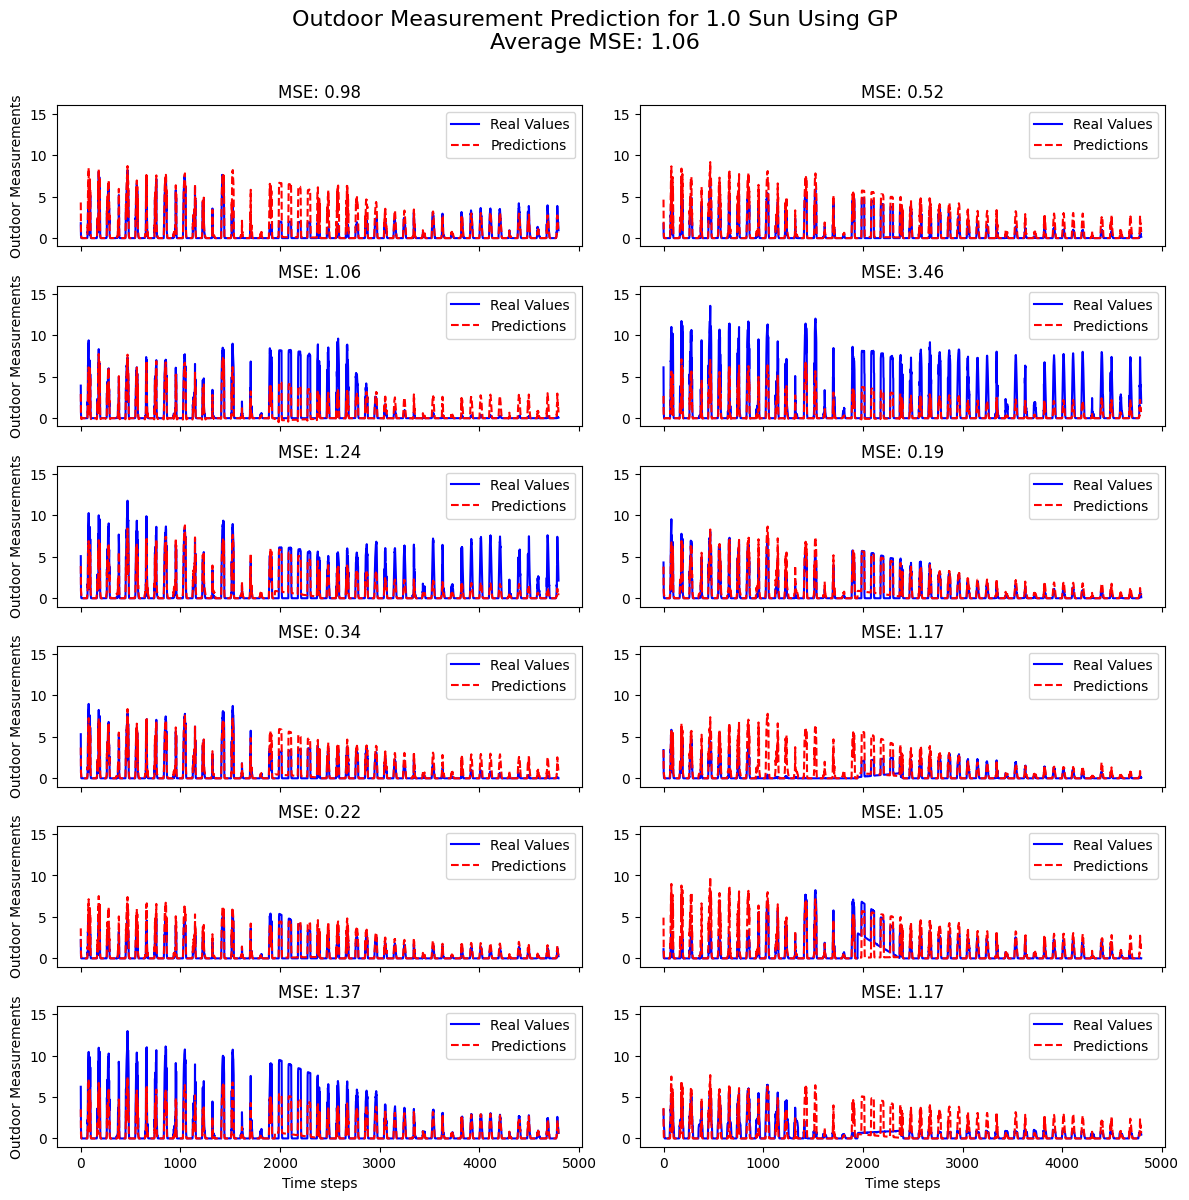

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(-1, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(-1, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 1.0 Sun Using GP\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.0 sun using GP.pdf')
plt.savefig('1.0 sun using GP.png')
plt.show()